### NMR shieldings
* Input molecule from SMILES,
* Optimization with MMFF then with ab-initio,
* Calculation of anisotropic shift



In [1]:
#####################################
#
# Computing NMR shielding constants
#
######################################
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdDetermineBonds, rdMolTransforms
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image, display
import pyscf
import gpu4pyscf
from gpu4pyscf import dft
from gpu4pyscf.properties.shielding import eval_shielding
from pyscf.geomopt.geometric_solver import optimize
from gpu4pyscf.dft import rks
import matplotlib.pyplot as plt
from pathlib import Path
import sys, time, random

### Definitions for the script
#smiles = r'CCCC(=S)N(CC)CC'  # Target molecule as SMILES
#smiles =r'CCC(C)CC(C)/C=C(C)/C=C/C=C/C(O)=C1\C(=O)NC(C(O)c2ccc(O)cc2)C1=O'  # r for raw string

smiles =r'CCCO'


randomKoords=True  # 3D embedding with random coordinates, default is False

#random Job-ID for temp- files
eintrags_id = random.randint(1, 100000000)

jobname = f"id{eintrags_id}"

# Filenames from jobname
xyzin =f"xyz/{jobname}.xyz"
logfile=f"logs/{jobname}_gpu.log"
logfile2=f"logs/{jobname}_nmr_gpu.log"
xyzfile=xyzin   # defines the name of the xyz file used in pySCF
xyzout=f"xyz/{jobname}_opt1.xyz"  # defines the output file for the optimization step
molbild = f"xyz/{jobname}.png"



def save_molecule_as_xyz(mol, filename):
    """save molecule as xyz- file"""
    with open(filename, 'w') as f:
        num_atoms = mol.GetNumAtoms()
        f.write(f"{num_atoms}\n\n")  # number of atoms and empty comment

        for atom in mol.GetAtoms():
            pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
            symbol = atom.GetSymbol()
            f.write(f"{symbol} {pos.x:.4f} {pos.y:.4f} {pos.z:.4f}\n")

molin = Chem.MolFromSmiles(smiles)

# Generate 3D coordinates
molin = Chem.AddHs(molin)  # add hydrogens
AllChem.EmbedMolecule(molin, useRandomCoords=randomKoords)  

# force field pre optimisation

max_iter=200
mmff_variant="MMFF94"
max_iterations = 40
counter = 0


status = AllChem.MMFFOptimizeMolecule(molin,mmff_variant)

if status == 0 : print("Optimization with force field successful")
if status == 1 : print("Further optimization required")
if status == -1 : print("Initialization failed")


while status == 1 and counter < max_iterations:
        status =AllChem.MMFFOptimizeMolecule(molin,mmff_variant, max_iter)  
        if counter == 0 : print("Further optimizations using force field starting")
        # Increase the counter
        counter += 1
        if status == 0 : print("Further optimization with force field successful")

print(f"Number of force field iterations: {counter}")
### Now the molecule should be optimized with the force field.

# save XYZfile
save_molecule_as_xyz(molin, xyzin)
print(f"XYZ-files {xyzin} succesful written.")



Optimization with force field successful
Number of force field iterations: 0
XYZ-files xyz/id12650.xyz succesful written.


geometric-optimize called with the following command line:
/home/steffen/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/steffen/.local/share/jupyter/runtime/kernel-35e55226-0842-48fb-bf12-9747a15b20a4.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **       

output file: logs/id12650_gpu.log


36 internal coordinates being used (instead of 36 Cartesians)
Internal coordinate system (atoms numbered from 1):
Distance 1-2
Distance 1-5
Distance 1-6
Distance 1-7
Distance 2-3
Distance 2-8
Distance 2-9
Distance 3-4
Distance 3-10
Distance 3-11
Distance 4-12
Angle 2-1-5
Angle 2-1-6
Angle 2-1-7
Angle 5-1-6
Angle 5-1-7
Angle 6-1-7
Angle 1-2-3
Angle 1-2-8
Angle 1-2-9
Angle 3-2-8
Angle 3-2-9
Angle 8-2-9
Angle 2-3-4
Angle 2-3-10
Angle 2-3-11
Angle 4-3-10
Angle 4-3-11
Angle 10-3-11
Angle 3-4-12
Dihedral 5-1-2-3
Dihedral 5-1-2-8
Dihedral 5-1-2-9
Dihedral 6-1-2-3
Dihedral 6-1-2-8
Dihedral 6-1-2-9
Dihedral 7-1-2-3
Dihedral 7-1-2-8
Dihedral 7-1-2-9
Dihedral 1-2-3-4
Dihedral 1-2-3-10
Dihedral 1-2-3-11
Dihedral 8-2-3-4
Dihedral 8-2-3-10
Dihedral 8-2-3-11
Dihedral 9-2-3-4
Dihedral 9-2-3-10
Dihedral 9-2-3-11
Dihedral 2-3-4-12
Dihedral 10-3-4-12
Dihedral 11-3-4-12
Translation-X 1-12
Translation-Y 1-12
Translation-Z 1-12
Rotation-A 1-12
Rotation-B 1-12
Rotation-C 1-12
<class 'geometric.internal.Dista

Optimized coordinate:
[[ 0.53840508  3.18802346  2.22057266]
 [ 1.17106096  1.22928402  0.18925511]
 [ 0.92870281 -1.46959086  1.15379956]
 [ 1.5524243  -3.13428363 -0.86289651]
 [ 0.72563718  5.11268504  1.48406004]
 [-1.40539669  2.9632215   2.90466308]
 [ 1.80232021  3.01459915  3.85437187]
 [-0.08268413  1.45318112 -1.44631807]
 [ 3.1057518   1.50415645 -0.5024948 ]
 [-1.01609021 -1.7991623   1.82973298]
 [ 2.2009592  -1.74779608  2.78219   ]
 [ 1.39751412 -4.85139103 -0.24750621]]
geometry optimization took 15.627716541290283 s



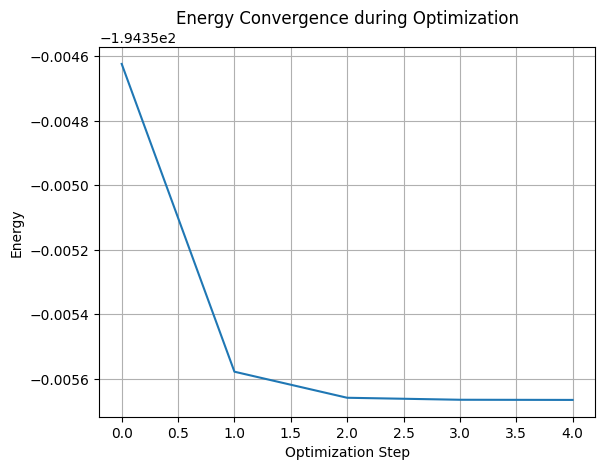

In [2]:
### Ab initio Geometry Optimization
### Molecule and Calculation Setup
### This can be shortened here

mol = pyscf.M(atom=xyzfile, basis='6-31g*', output=logfile)
mf_GPU = rks.RKS(mol, xc='b3lyp').density_fit()
mf_GPU.disp = 'd3bj'
mf_GPU.grids.level = 3
mf_GPU.conv_tol = 1e-10   # 1e-10 in original example
mf_GPU.max_cycle = 50   # 50 in original example

# lists for energy and gradients
energies = []
gradients = []

def callback(envs):
    energies.append(envs['energy'])  # save energy
    gradients.append(envs['gradients'])



start_time = time.time()
mol_eq = optimize(mf_GPU, maxsteps=50, callback=callback)  #maxtsep = 20 im Original
print("Optimized coordinate:")
print(mol_eq.atom_coords())
print('geometry optimization took', time.time() - start_time, 's')
print()
# Plotting the SCF energies
plt.plot(energies)
plt.title('Energy Convergence during Optimization')
plt.xlabel('Optimization Step')
plt.ylabel('Energy')
plt.grid(True)
plt.show()


In [3]:
# 
# save genometry
#
print(mol_eq.tostring(format='xyz')) # from user guide

mol_eq.tofile(xyzout, format='xyz')

12
XYZ from PySCF
C           0.28491        1.68703        1.17508
C           0.61970        0.65051        0.10015
C           0.49145       -0.77767        0.61056
O           0.82151       -1.65859       -0.45663
H           0.38399        2.70552        0.78533
H          -0.74370        1.56807        1.53708
H           0.95375        1.59526        2.03965
H          -0.04375        0.76899       -0.76536
H           1.64349        0.79597       -0.26591
H          -0.53769       -0.95208        0.96825
H           1.16470       -0.92489        1.47227
H           0.73953       -2.56725       -0.13097


'12\nXYZ from PySCF\nC           0.28491        1.68703        1.17508\nC           0.61970        0.65051        0.10015\nC           0.49145       -0.77767        0.61056\nO           0.82151       -1.65859       -0.45663\nH           0.38399        2.70552        0.78533\nH          -0.74370        1.56807        1.53708\nH           0.95375        1.59526        2.03965\nH          -0.04375        0.76899       -0.76536\nH           1.64349        0.79597       -0.26591\nH          -0.53769       -0.95208        0.96825\nH           1.16470       -0.92489        1.47227\nH           0.73953       -2.56725       -0.13097'

In [4]:
####################################
#
# Molecule result view
#
####################################


import py3Dmol

# build 3D object
view = py3Dmol.view(width=800, height=400)

# read xyz files
with open(xyzout, 'r') as file:
    xyz_data = file.read()

# add dxata to view
view.addModel(xyz_data, 'xyz')

# Set the representation (e.g., as spheres and rods).
view.setStyle({'stick': {}})


# Render view
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
# NMR calculation

start_time = time.time()

dateipfad = Path(xyzout)

if dateipfad.exists():
    print("file exist.")
else:
    print("file not exist.")
    sys.exit(1)

mol = pyscf.M(atom=xyzout, basis='6-31g*', output=logfile2)
mf = dft.RKS(mol)
mf.xc = 'b3lyp'
mf.kernel()
tensor = eval_shielding(mf)


abschirmung = tensor[0].get()+tensor[1].get()
end_time = time.time()
print(f'Walltime: {end_time-start_time} Seconds')
print("The program can continue.")

file exist.
output file: logs/id12650_nmr_gpu.log
Walltime: 6.729905366897583 Seconds
The program can continue.


In [6]:
#################################################################################################
#
# Constanten für Verschiebungsberchnung
#
# CSHESHIRE Repository (Tantillo)
#
#
# delta = (intercept -sigma)/ - slope
#
# The sign of the slope is incorporated directly into the definition of the constant.
#
# TMS shielding calculated independently. delta = sigma - TMS
#
##################################################################################################

intercept1a = 187.4743
slope1a = 0.9269
intercept1b = 188.4418
slope1b = 0.9449
intercept1c = 188.01
slope1c = 0.9378
tmsshield = 190.2218

shift = [0] *mol.natm
shift1a = [0] *mol.natm
shift1b= [0] *mol.natm
shift1c= [0] *mol.natm
shifttms= [0] *mol.natm


data = []
for i in range(mol.natm):
    shift[i]= (abschirmung[i,0,0] + abschirmung[i,1,1] + abschirmung[i,2,2])/3
    

    if  mol._atom[i][0] =='C':
        shift1a[i] = (intercept1a-shift[i])/slope1a
        shift1b[i] = (intercept1b-shift[i])/slope1b
        shift1c[i] = (intercept1c-shift[i])/slope1c
        shifttms[i] = tmsshield - shift[i]
        data.append({'Atom': mol._atom[i][0], 'Index': i+1, 'Totale shielding': shift[i], 'table1a': shift1a[i], 'table1b' : shift1b[i], 'table1c' : shift1c[i], 'TMS' : shifttms[i]})

print("continue")

continue


In [7]:
import pandas as pd
from IPython.display import display, HTML
# build DataFrame
df = pd.DataFrame(data)

# SSet the column headers
df.columns = ['Atom', 'Index', 'Totale shierlding', 'table1a', 'table1b', 'table1c', 'TMS']

# Use the Styler to change the font size
styled_df = df.style.set_table_attributes('style="font-size: 17px;"')  # Ändere die Schriftgröße hier

# show table
display(HTML(f"<h2 style=color:#069>{jobname}</h2>"))
display(styled_df)



,Atom,Index,Totale shierlding,table1a,table1b,table1c,TMS
0,C,1,178.689041,9.478108,10.321472,9.939175,11.532759
1,C,2,163.856889,25.479998,26.018532,25.755076,26.364911
2,C,3,125.287866,67.090769,66.836632,66.882207,64.933934


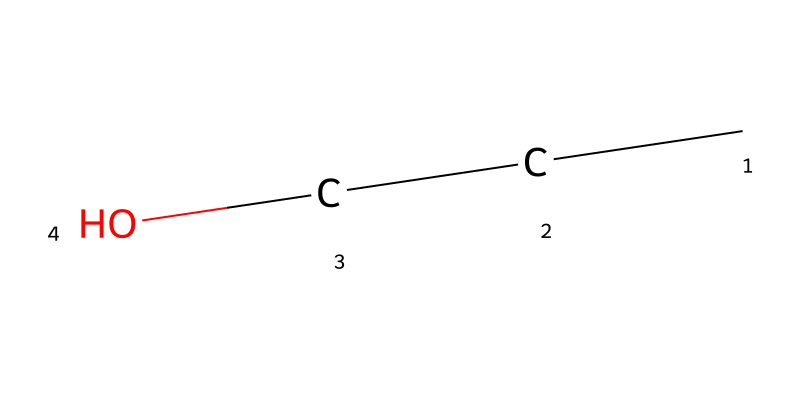

In [8]:

def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx() + 1))
    return mol

# read molecule

raw_mol = Chem.MolFromXYZFile(xyzout)

if raw_mol is not None:
    mol2 = Chem.Mol(raw_mol)
    Chem.rdDetermineBonds.DetermineBonds(mol2)

    # build 2D coordinates
    AllChem.Compute2DCoords(mol2)

    # show atom numbers
    show_atom_number(mol2, 'atomNote')


    ### remove hydrogen
    mol3 = Chem.RemoveHs(mol2)
    # Change the size of the molecule representation and save the image
    img = Draw.MolToImage(mol3, size=(800, 400))  # define size
    img.save(molbild)  # save image
    display(Image(filename=molbild))
else:
    print("Error loading molecule from XYZ file.")